# Perylene 

### Imports and functions

In [22]:
import cmeutils
from cmeutils.structure import gsd_rdf, get_quaternions, diffraction_pattern,all_atom_rdf #, k_vector_to_length #, bragg_angle_to_length
import freud
from freud.diffraction import DiffractionPattern, StaticStructureFactorDirect
import gsd.hoomd
import numpy as np
import matplotlib.pyplot as plt
import signac
import os

# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 1
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.marker"] = "o"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200

def snapshot_to_freud(snapshot, ref_distance):
    box = snapshot.configuration.box
    box[0:3] *= ref_distance
    xyz = snapshot.particles.position * ref_distance
    return freud.locality.NeighborQuery.from_system(system=(box, xyz))

In [2]:
project = signac.get_project()
project

,sp.density,sp.n_compounds,sp.system_kwargs,sp.remove_hydrogens,sp.remove_charges,sp.tau_kt,sp.dt,sp.r_cut,sp.sim_seed,sp.shrink_steps,...,sp.kT,sp.n_steps,doc.done,doc.equilibrated,doc.run,doc.ref_distance,doc.ref_mass,doc.ref_energy,doc.target_box,doc.order
adcc72f3871a8b421e59239b91f93651,0.5,250,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,1.150,1000000.0,True,True,2,3.39967,2.161856e-26,0.086,"[17.46966910027839, 17.46966910027839, 17.4696...",None
be6fb83e167f41de4743ac240026cb6a,0.5,250,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,5.749,1000000.0,True,True,5,3.39967,2.161856e-26,0.086,"[17.46966910027839, 17.46966910027839, 17.4696...",None
0c622a888250aa9bbf57d5ddddfdba79,0.5,250,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,11.500,1000000.0,True,True,1,3.39967,2.161856e-26,0.086,"[17.46966910027839, 17.46966910027839, 17.4696...",None
7927252a203dbc0fa79980467266fd57,0.5,250,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,17.250,1000000.0,True,True,1,3.39967,2.161856e-26,0.086,"[17.46966910027839, 17.46966910027839, 17.4696...",None
6e20ddda809fb56df4a031f45693ead9,1.0,250,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,1.150,1000000.0,True,True,4,3.39967,2.161856e-26,0.086,"[13.865685553659137, 13.865685553659137, 13.86...",None
e08b6b3152f900def3e587c67c92dbe3,1.0,250,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,5.749,1000000.0,True,True,4,3.39967,2.161856e-26,0.086,"[13.865685553659137, 13.865685553659137, 13.86...",None
44862962f1297a5da5e5d0e49bcebc5b,1.0,250,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,11.500,1000000.0,True,True,1,3.39967,2.161856e-26,0.086,"[13.865685553659137, 13.865685553659137, 13.86...",None
63ebc77f4ba291edbe7c399bc73a0559,1.0,250,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,17.250,1000000.0,True,True,2,3.39967,2.161856e-26,0.086,"[13.865685553659137, 13.865685553659137, 13.86...",None
2203df14eed015f481e392417f69f10e,1.5,250,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,1.150,1000000.0,True,True,2,3.39967,2.161856e-26,0.086,"[12.112792029852933, 12.112792029852933, 12.11...",None
e0071f34cac97371cbe8d40f36e87bf1,1.5,250,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,5.749,1000000.0,True,True,1,3.39967,2.161856e-26,0.086,"[12.112792029852933, 12.112792029852933, 12.11...",None


## RDF Calculations

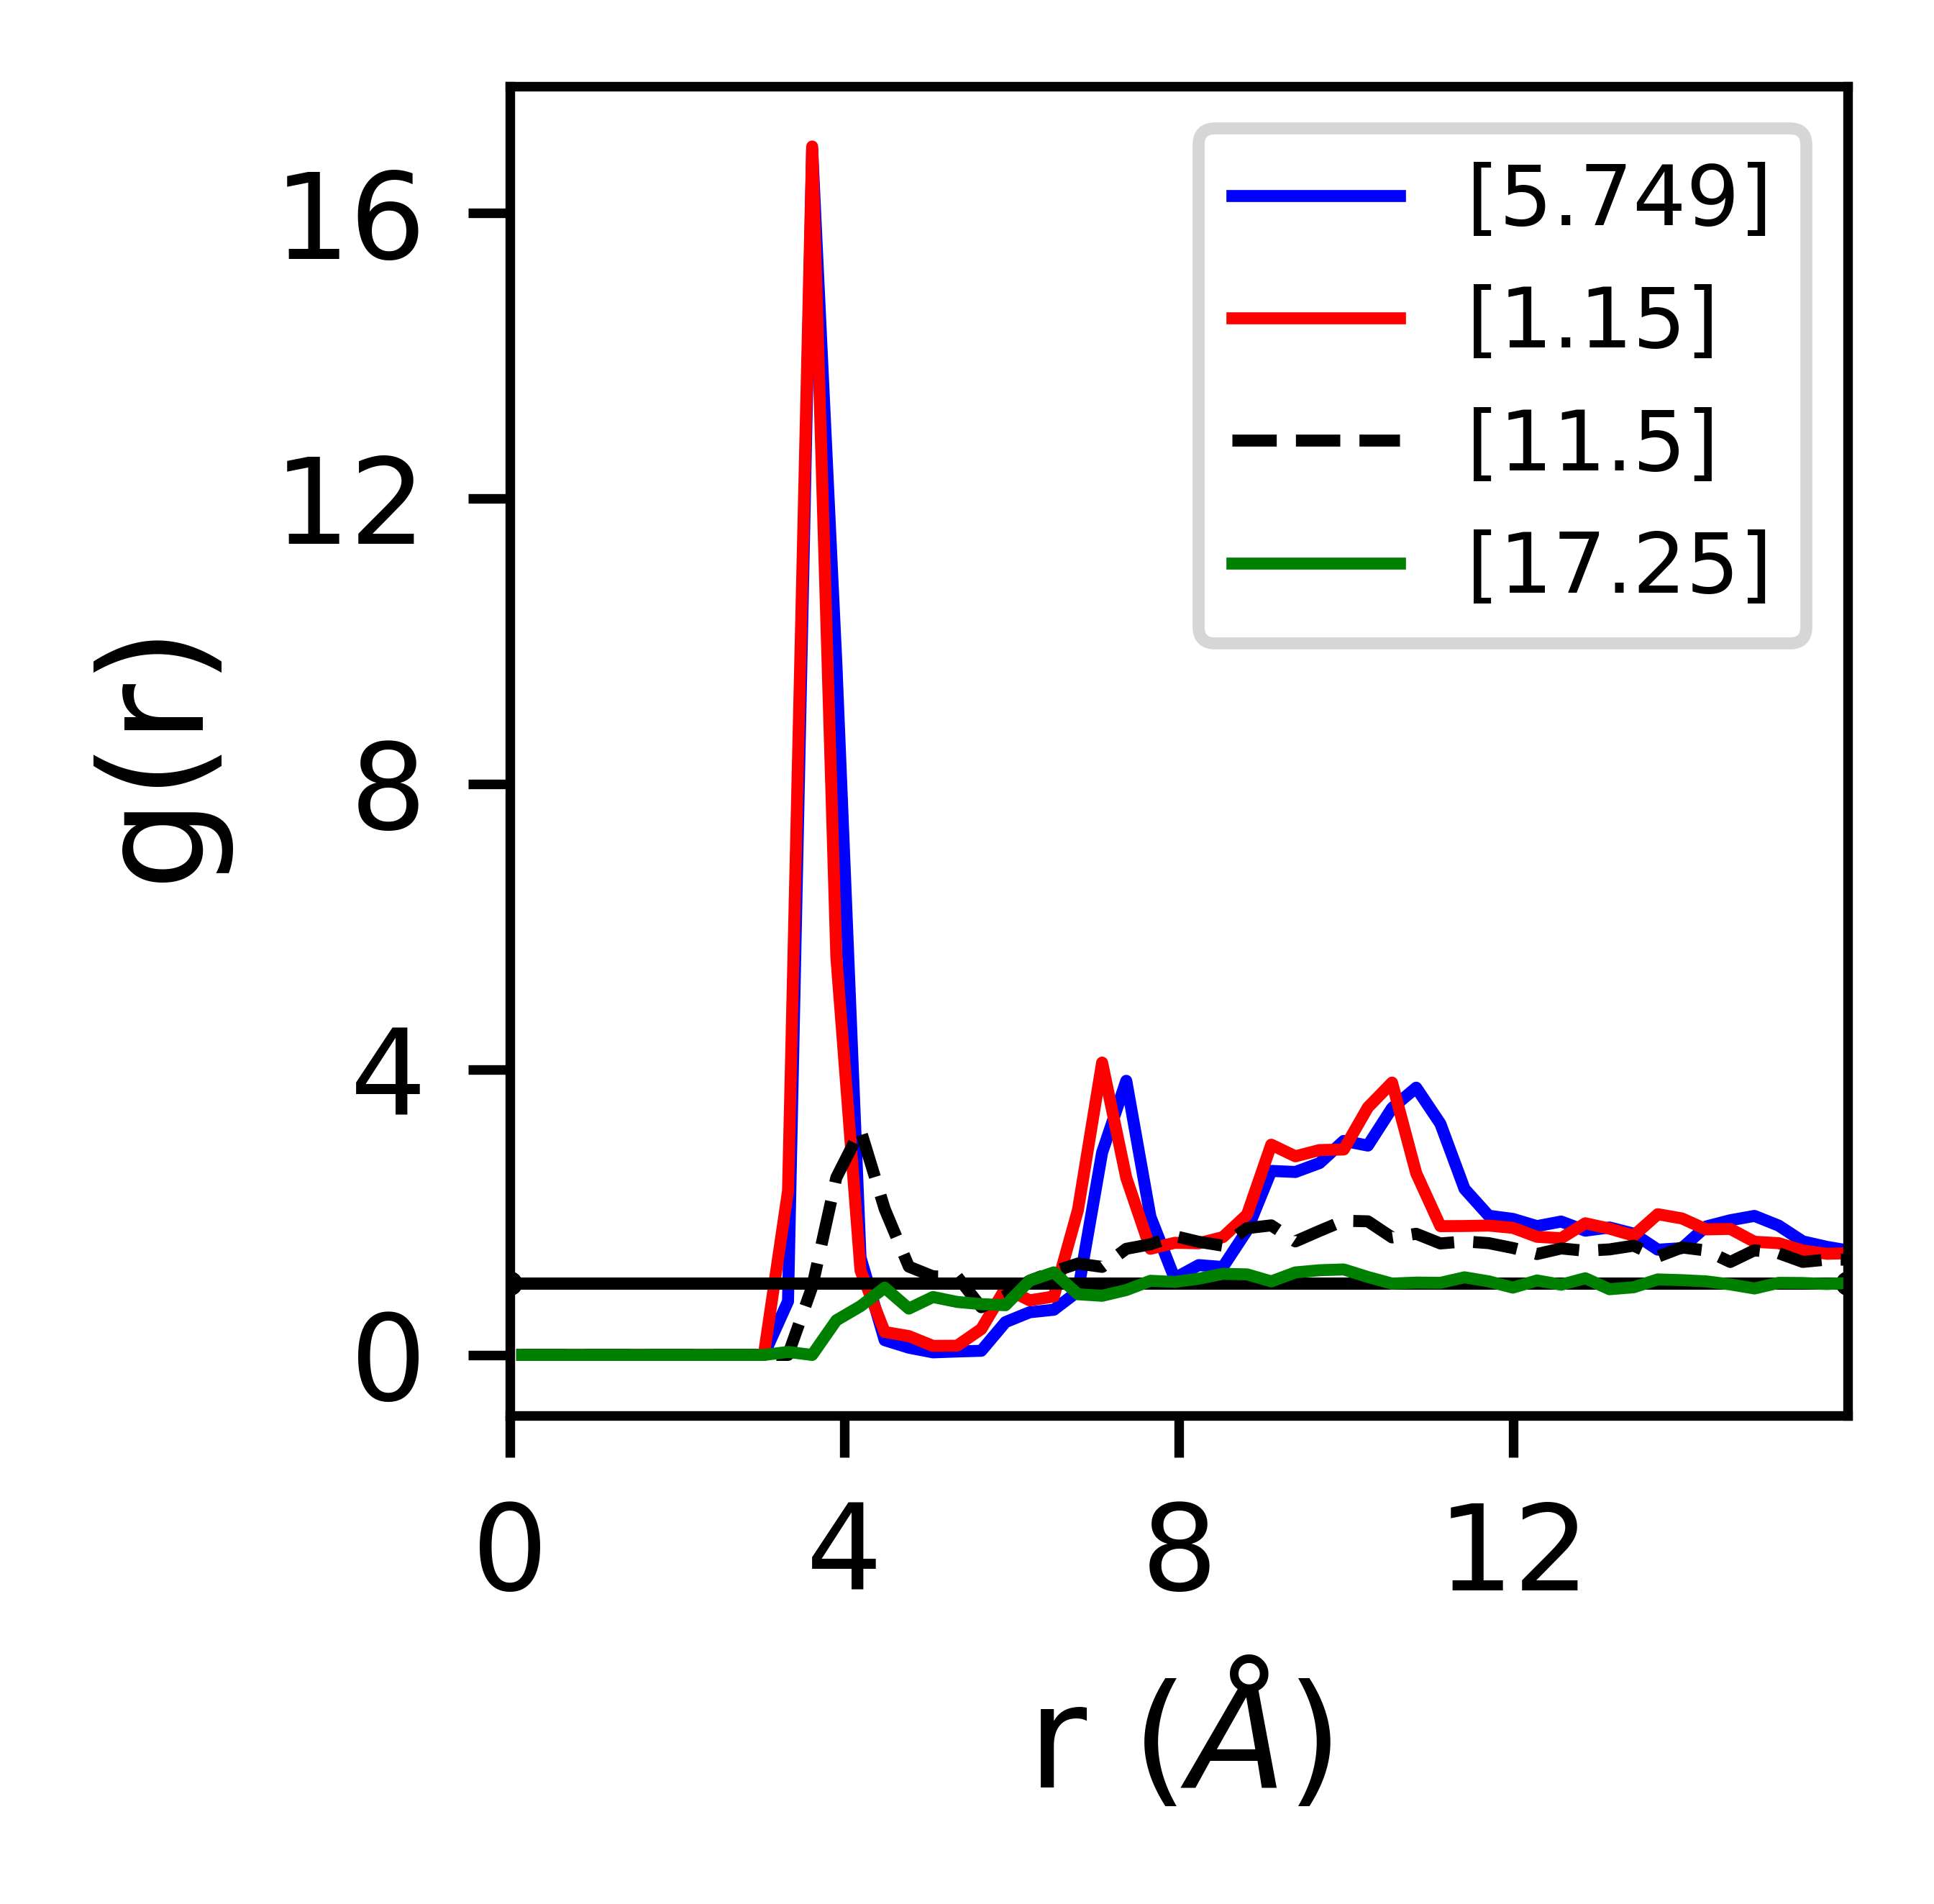

In [23]:
## from atom centers:
for job in project.find_jobs({"density":0.5}):
    if job.doc.equilibrated == True:
        if os.path.isfile(job.fn('perylene-cg.gsd')):
            with gsd.hoomd.open(job.fn('perylene-cg.gsd'),mode='r') as trajectory:
                snap = trajectory[-1]
            rdf, N = gsd_rdf(
                gsdfile= job.fn('perylene-cg.gsd'),
                A_name='_A',
                B_name='_A',
                start=-5,
                stop=-1,
                r_max=8.5,
                exclude_bonded=True
            )
        LABEL = [job.sp.kT,job.sp.density]
        plt.axhline(y = 1.0, color ="black", linestyle ="-") 
        if job.sp.kT == 5.749:
            c = 'blue'
            m = '-'
        if job.sp.kT == 1.15:
            c = 'red'
            m = '-'
        if job.sp.kT == 11.5:
            c = 'black'
            m = '--'
        if job.sp.kT == 17.25:
            c = 'green'
            m = '-'
        plt.plot(rdf.bin_centers*job.doc.ref_distance, rdf.rdf*N,label=[job.sp.kT],color=c,marker='None',linestyle=m)
plt.legend()
plt.xlabel("r ($\AA$)")
plt.ylabel("g(r)")
plt.xlim(0,16)
plt.xticks(np.arange(0,16,4))
plt.yticks(np.arange(0,18,4))
plt.show()

## Diffraction Pattern

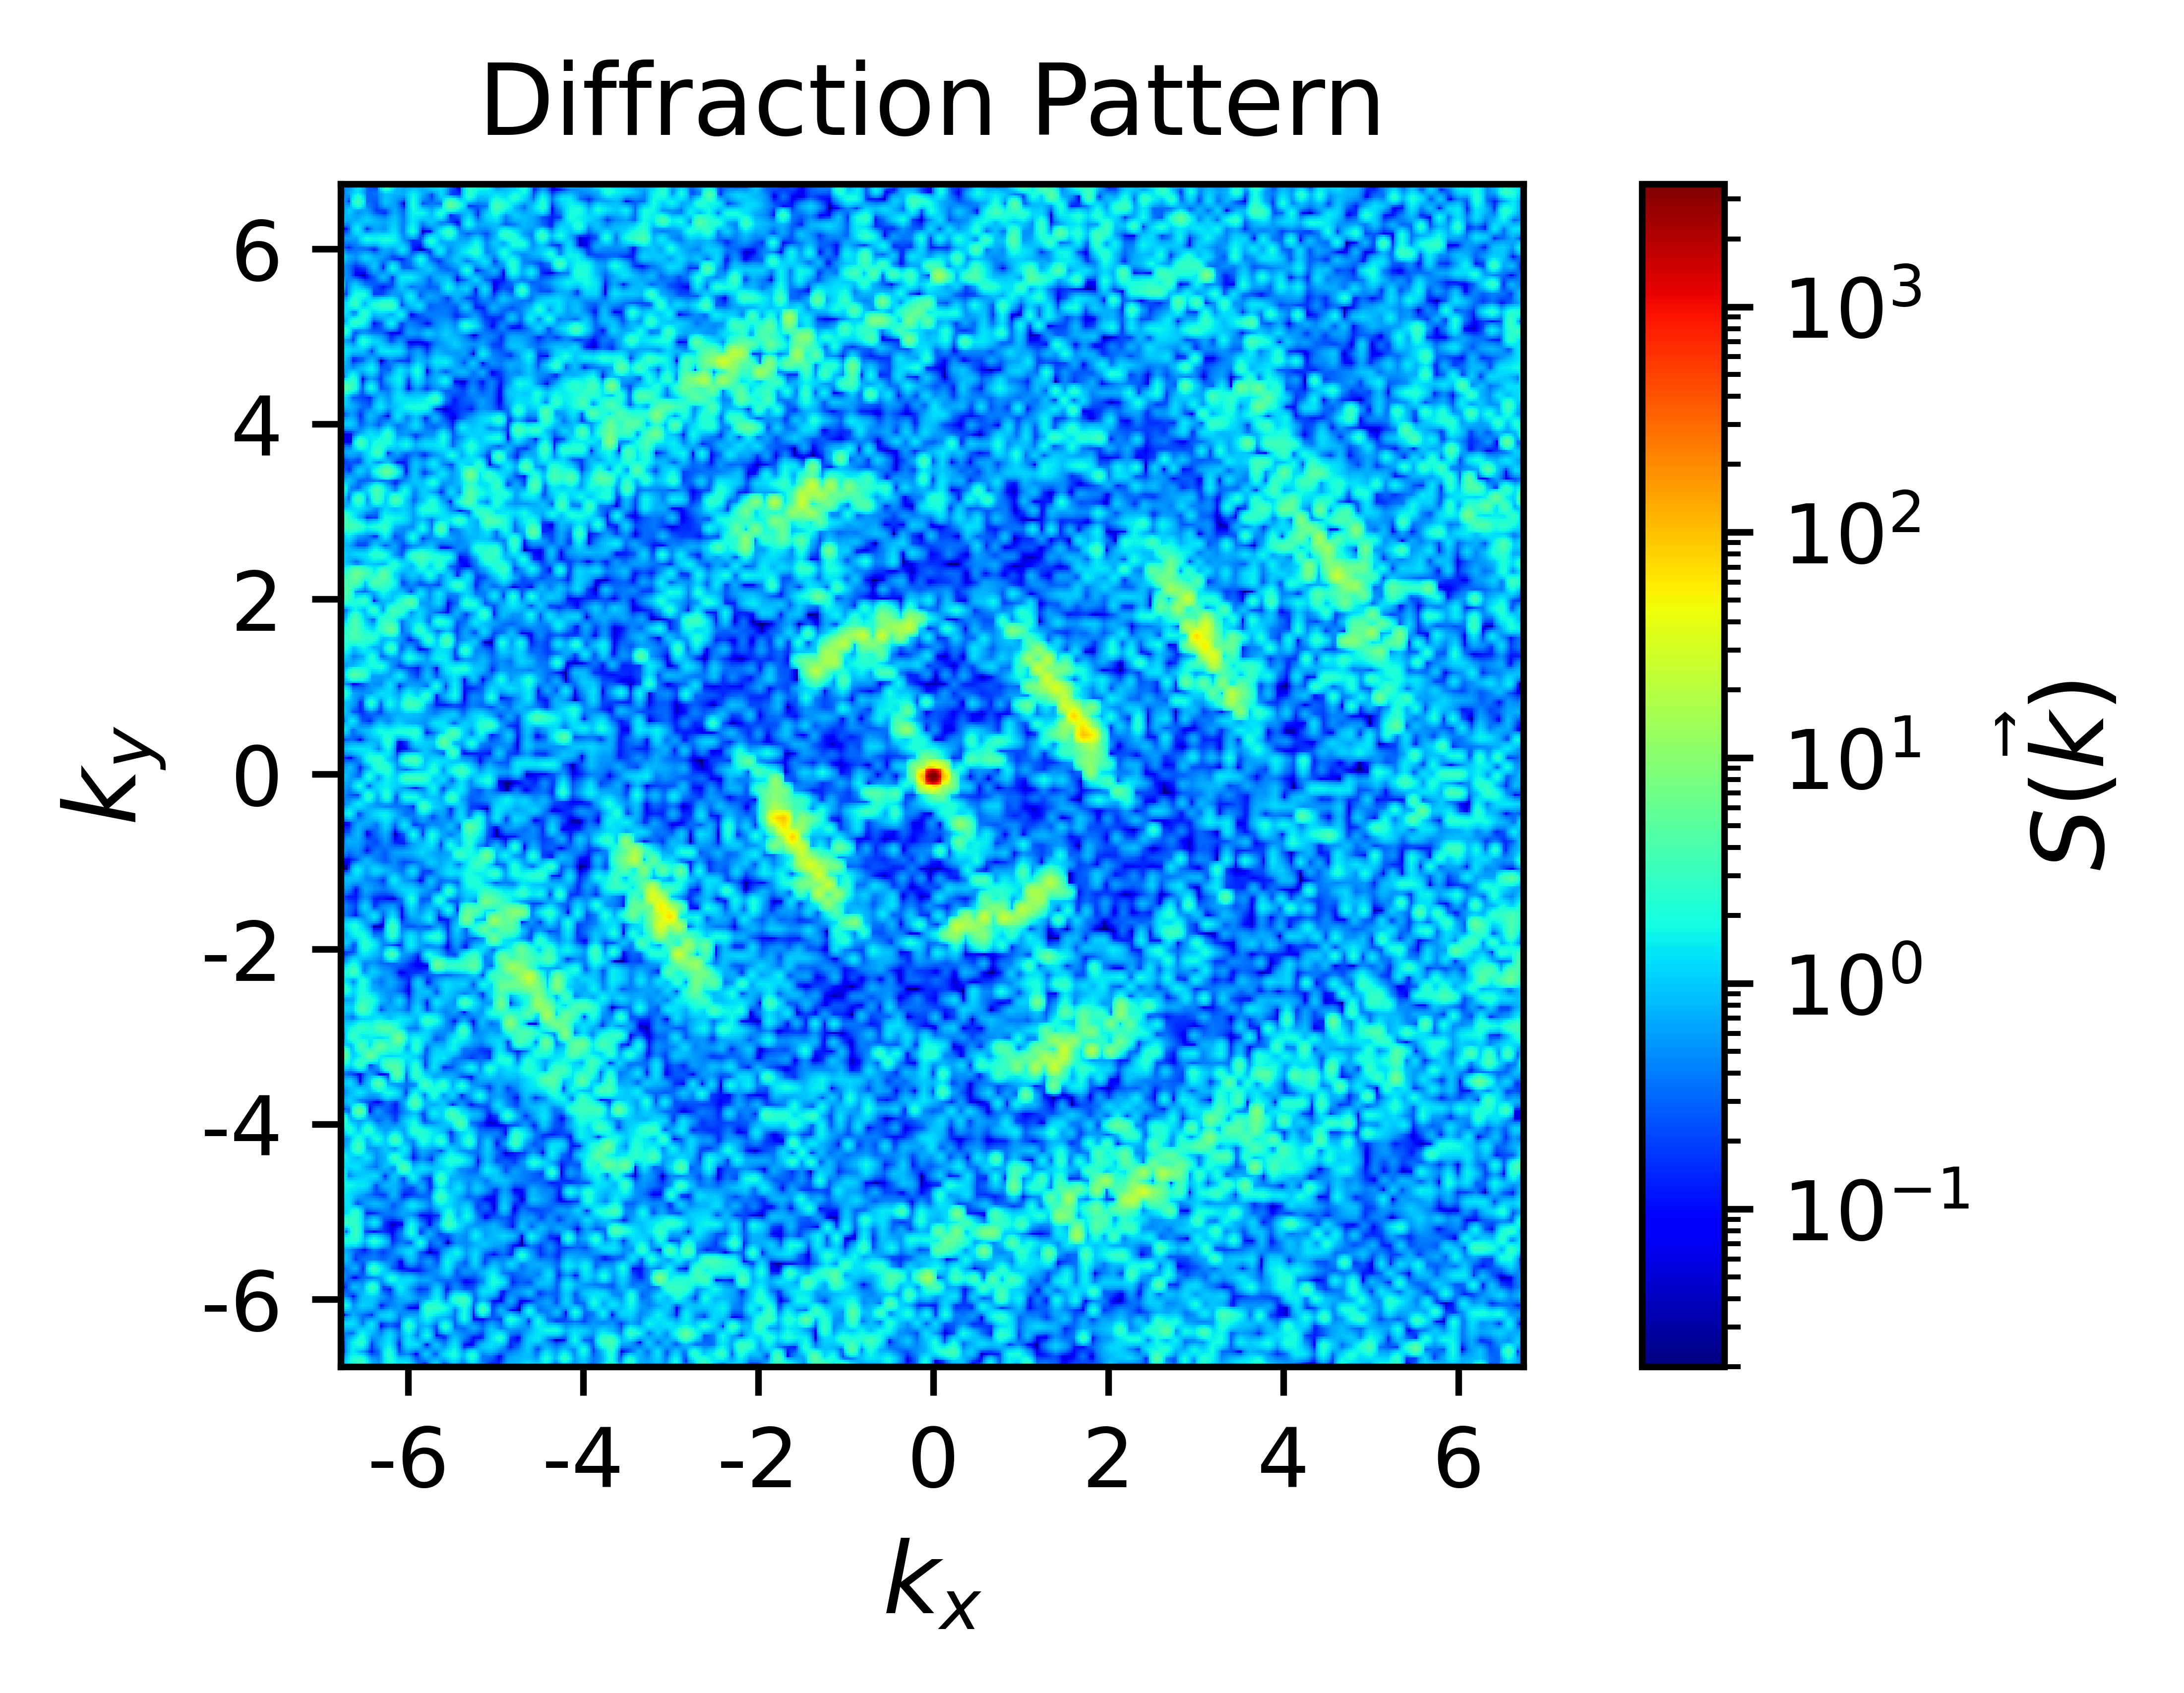

In [4]:
for job in project.find_jobs({"density":0.5,"kT":5.749}):
    snap = gsd.hoomd.open(job.fn(f"trajectory{job.doc.run}.gsd"))[-1]
    system = snapshot_to_freud(snap, job.doc.ref_distance)
    
    dp = DiffractionPattern(grid_size=512)
    dp.compute(system=system, view_orientation=[ 6.12323400e-17,6.77260071e-01,-2.13902392e-02,7.35432699e-01],
               reset=False)
    dp.plot(cmap="jet")